In [1]:
from transformers import GLPNImageProcessor, GLPNForDepthEstimation
from matplotlib import pyplot as plt
from PIL import Image
import open3d as o3d
import numpy as np
import torch

2023-06-20 05:40:58.152667: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 05:40:58.843187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
feature_extractor = GLPNImageProcessor.from_pretrained('vinvino02/glpn-nyu')
model             = GLPNForDepthEstimation.from_pretrained('vinvino02/glpn-nyu')

image             = Image.open('assets/cat.jpg')
new_H             = 480 if image.height > 480 else image.height

new_H            -= (new_H % 32)
new_W             = int(new_H * image.width / image.height)

diff              = new_W % 32
new_W             = new_W - diff if diff < 16 else new_W + 32 - diff
new_size          = (new_W, new_H)
image             = image.resize(new_size)

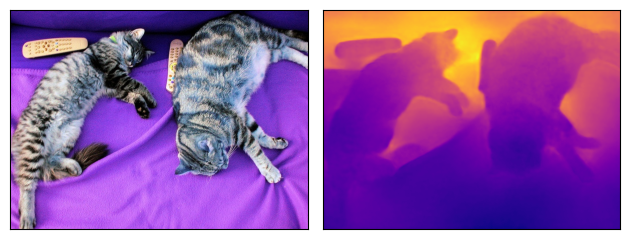

In [3]:
inputs = feature_extractor(images = image, return_tensors = 'pt')

with torch.no_grad():
    outputs         = model(**inputs)
    predicted_depth = outputs.predicted_depth
    
pad    = 16
output = predicted_depth.squeeze().cpu().numpy() * 1000.0
output = output[pad: -pad, pad: -pad]

image   = image.crop((pad, pad, image.width - pad, image.height - pad))
fig, ax = plt.subplots(1, 2)

ax[0].imshow(image)
ax[0].tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
ax[1].imshow(output, cmap = 'plasma')
ax[1].tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)

plt.tight_layout()
plt.pause(5)

In [4]:
width, height = image.size
depth_image   = (output * 255 / np.max(output)).astype('uint8')
image         = np.array(image)

depth_map     = o3d.geometry.Image(depth_image)
rgb_image     = o3d.geometry.Image(image)
rgbd_image    = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_image, depth_map,
                                                                   convert_rgb_to_intensity = False)

camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width, height, 500, 500, width / 2, height / 2)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)

In [7]:
pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()

mesh     = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth = 10, n_threads = 1)[0]
rotation = mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
mesh.rotate(rotation, center = (0, 0, 0))

o3d.io.write_triangle_mesh(f'./mesh.obj', mesh)
o3d.visualization.draw_geometries([mesh], mesh_show_back_face = True)

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


- 으악 징그러
![으악 징그러](../../../assets/AI/GLPN/cat.jpeg)